### Importing Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1
[notice] To update, run: pip install --upgrade pip


## Question 1:
### Data Exploration & Preparation:

Training data size: 60000 images
Testing data size: 10000 images
Image dimensions (Training): 28x28
Image dimensions (Testing): 28x28
Number of unique classes: 10


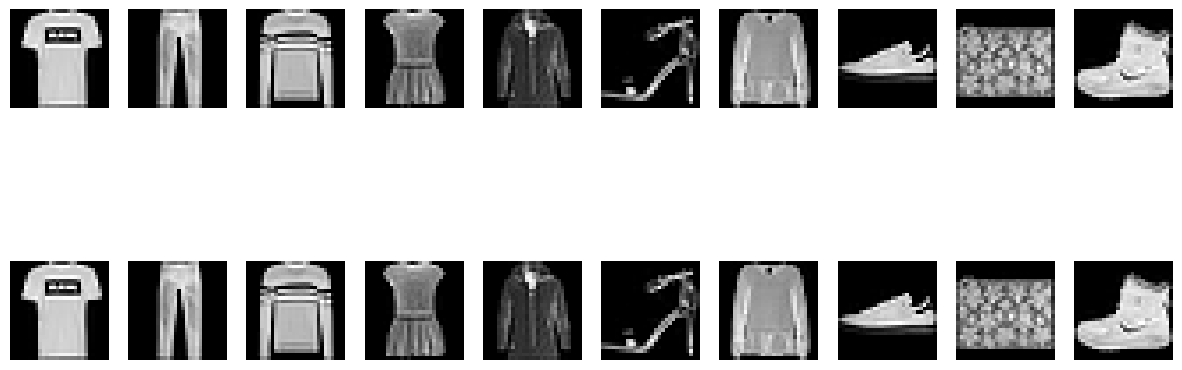

In [3]:
# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Verify the size of the datasets
print(f"Training data size: {x_train.shape[0]} images")
print(f"Testing data size: {x_test.shape[0]} images")

# Verify the dimensions of each image
print(f"Image dimensions (Training): {x_train.shape[1]}x{x_train.shape[2]}")
print(f"Image dimensions (Testing): {x_test.shape[1]}x{x_test.shape[2]}")

# Verify the number of classes
print(f"Number of unique classes: {len(np.unique(y_train))}")

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Visualizing sample images (20 images in this case)
fig, ax = plt.subplots(2, 10, figsize=(15, 6))  # 2 rows, 10 columns
for i in range(20):
    ax[i // 10, i % 10].imshow(x_train[y_train.argmax(axis=1) == i % 10][0], cmap='gray')
    ax[i // 10, i % 10].axis('off')
plt.show()

### Data Splitting:

In [4]:
# 1. Load the entire Fashion MNIST (60K train + 10K test = 70K total)
(x0, y0), (x1, y1) = fashion_mnist.load_data()
x = np.concatenate([x0, x1], axis=0)
y = np.concatenate([y0, y1], axis=0)

# 2. Normalize and reshape
x = x.astype("float32") / 255.0
x = x.reshape(-1, 28, 28, 1)
y = to_categorical(y, 10)

# 3. First split off 4% for test
x_temp, x_test, y_temp, y_test = train_test_split(
    x, y,
    test_size=0.04,
    random_state=42,
    stratify=y
)

# 4. Then split the remaining 96% into 85% train + 10% val:
val_rel = 0.10 / 0.96
x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp,
    test_size=val_rel,
    random_state=42,
    stratify=y_temp
)
total = len(x)
print(f"Train  : {len(x_train)/total*100:5.2f}%")
print(f"Val    : {len(x_val)  /total*100:5.2f}%")
print(f"Test   : {len(x_test) /total*100:5.2f}%")


Train  : 86.00%
Val    : 10.00%
Test   :  4.00%


### Model Development without batch normalization

In [5]:
# Model 1: Shallow Neural Network
model1 = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Model 2: Basic CNN
model2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Model 3: Deeper CNN
model3 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Print summaries of models


In [8]:
model1.summary()
model2.summary()
model3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       692,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,962 (2.65 MB)

 Trainable params: 693,962 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,522 (3.42 MB)

 Trainable params: 896,522 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

### Training & Validation:

#### Training Model 1:

In [9]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("NumS:", len(tf.config.list_physical_devices('GPU')))


TF version: 2.19.0
NumS: 0


In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [11]:
# 1. Create the checkpoint callback
checkpoint1 = ModelCheckpoint(
    'model1_weights.h5',   # filepath to save the best weights
    monitor='val_loss',         # metric to monitor
    save_best_only=True,        # only save when val_loss improves
    mode='min',                 # we want to minimize val_loss
    verbose=1
)

# 2. Train with the callback
history1 = model1.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint1]     
)

Epoch 1/50
1804/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - accuracy: 0.7761 - loss: 0.6432
Epoch 1: val_loss improved from inf to 0.40077, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 2s 667us/step - accuracy: 0.7780 - loss: 0.6375 - val_accuracy: 0.8587 - val_loss: 0.4008
Epoch 2/50
1868/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - accuracy: 0.8595 - loss: 0.3925
Epoch 2: val_loss improved from 0.40077 to 0.36268, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 616us/step - accuracy: 0.8595 - loss: 0.3924 - val_accuracy: 0.8701 - val_loss: 0.3627
Epoch 3/50
1808/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - accuracy: 0.8736 - loss: 0.3466
Epoch 3: val_loss improved from 0.36268 to 0.35113, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.8736 - loss: 0.3465 - val_accuracy: 0.8746 - val_loss: 0.3511
Epoch 4/50
1832/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step - accuracy: 0.8809 - loss: 0.3223
Epoch 4: val_loss improved from 0.35113 to 0.33033, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - accuracy: 0.8809 - loss: 0.3222 - val_accuracy: 0.8800 - val_loss: 0.3303
Epoch 5/50
1850/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - accuracy: 0.8878 - loss: 0.3041
Epoch 5: val_loss improved from 0.33033 to 0.32259, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - accuracy: 0.8878 - loss: 0.3041 - val_accuracy: 0.8844 - val_loss: 0.3226
Epoch 6/50
1834/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.8971 - loss: 0.2845
Epoch 6: val_loss improved from 0.32259 to 0.32130, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 596us/step - accuracy: 0.8970 - loss: 0.2845 - val_accuracy: 0.8834 - val_loss: 0.3213
Epoch 7/50
1824/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 579us/step - accuracy: 0.8993 - loss: 0.2699
Epoch 7: val_loss did not improve from 0.32130
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.8993 - loss: 0.2700 - val_accuracy: 0.8817 - val_loss: 0.3258
Epoch 8/50
1793/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - accuracy: 0.9025 - loss: 0.2603
Epoch 8: val_loss improved from 0.32130 to 0.31983, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 580us/step - accuracy: 0.9025 - loss: 0.2604 - val_accuracy: 0.8881 - val_loss: 0.3198
Epoch 9/50
1854/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step - accuracy: 0.9050 - loss: 0.2543
Epoch 9: val_loss improved from 0.31983 to 0.31022, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 566us/step - accuracy: 0.9050 - loss: 0.2543 - val_accuracy: 0.8893 - val_loss: 0.3102
Epoch 10/50
1863/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.9081 - loss: 0.2478
Epoch 10: val_loss did not improve from 0.31022
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.9081 - loss: 0.2478 - val_accuracy: 0.8849 - val_loss: 0.3245
Epoch 11/50
1871/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.9132 - loss: 0.2362
Epoch 11: val_loss improved from 0.31022 to 0.30962, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9132 - loss: 0.2362 - val_accuracy: 0.8934 - val_loss: 0.3096
Epoch 12/50
1873/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - accuracy: 0.9155 - loss: 0.2264
Epoch 12: val_loss did not improve from 0.30962
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - accuracy: 0.9155 - loss: 0.2265 - val_accuracy: 0.8847 - val_loss: 0.3147
Epoch 13/50
1833/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - accuracy: 0.9177 - loss: 0.2159
Epoch 13: val_loss improved from 0.30962 to 0.30780, saving model to model1_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.9177 - loss: 0.2161 - val_accuracy: 0.8934 - val_loss: 0.3078
Epoch 14/50
1869/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - accuracy: 0.9192 - loss: 0.2172
Epoch 14: val_loss did not improve from 0.30780
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 557us/step - accuracy: 0.9192 - loss: 0.2172 - val_accuracy: 0.8964 - val_loss: 0.3082
Epoch 15/50
1821/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - accuracy: 0.9219 - loss: 0.2089
Epoch 15: val_loss did not improve from 0.30780
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 745us/step - accuracy: 0.9219 - loss: 0.2089 - val_accuracy: 0.8990 - val_loss: 0.3082
Epoch 16/50
1847/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.9243 - loss: 0.2036
Epoch 16: val_loss did not improve from 0.30780
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 1s 618us/step - accuracy: 0.9243 - loss: 0.2036 - val_accuracy: 0.8927 - val_loss: 0.3134
Epoch 17/50
1827/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.9254 - loss: 0.1968
Epoch 17

#### Training Model 2:

In [12]:
# 1. Create the checkpoint callback for model2
checkpoint2 = ModelCheckpoint(
    'model2_weights.h5',  # filepath to save the best weights
    monitor='val_loss',                # metric to monitor
    save_best_only=True,               # only save when val_loss improves
    mode='min',                        # we want to minimize val_loss
    verbose=1
)

# 2. Train model2 with the checkpoint callback
history2 = model2.fit(
    x_train,
    y_train,
    epochs=50,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint2]            
)


Epoch 1/50
1876/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8157 - loss: 0.5338
Epoch 1: val_loss improved from inf to 0.30310, saving model to model2_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8159 - loss: 0.5333 - val_accuracy: 0.8950 - val_loss: 0.3031
Epoch 2/50
1869/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9007 - loss: 0.2786
Epoch 2: val_loss improved from 0.30310 to 0.26835, saving model to model2_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9007 - loss: 0.2785 - val_accuracy: 0.9023 - val_loss: 0.2684
Epoch 3/50
1874/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9170 - loss: 0.2258
Epoch 3: val_loss did not improve from 0.26835
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9170 - loss: 0.2258 - val_accuracy: 0.9003 - val_loss: 0.2756
Epoch 4/50
1873/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9297 - loss: 0.1901
Epoch 4: val_loss improved from 0.26835 to 0.24289, saving model to model2_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9297 - loss: 0.1901 - val_accuracy: 0.9129 - val_loss: 0.2429
Epoch 5/50
1872/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9379 - loss: 0.1680
Epoch 5: val_loss improved from 0.24289 to 0.24072, saving model to model2_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9379 - loss: 0.1680 - val_accuracy: 0.9146 - val_loss: 0.2407
Epoch 6/50
1875/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9479 - loss: 0.1404
Epoch 6: val_loss did not improve from 0.24072
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9479 - loss: 0.1405 - val_accuracy: 0.9094 - val_loss: 0.2678
Epoch 7/50
1873/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9542 - loss: 0.1239
Epoch 7: val_loss did not improve from 0.24072
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9542 - loss: 0.1239 - val_accuracy: 0.9186 - val_loss: 0.2457
Epoch 8/50
1879/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9621 - loss: 0.1058
Epoch 8: val_loss did not improve from 0.24072
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9621 - loss: 0.1058 - val_accuracy: 0.9161 - val_loss: 0.2562
Epoch 9/50
1873/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9691 - loss: 0.0879
Epoch 9: val_loss did not impro

#### Training Model 3:

In [13]:
# Define the checkpoint callback to save the best weights based on validation loss
checkpoint_callback = ModelCheckpoint(
    'model3_weights.h5',      # Save the best weights to this file
    monitor='val_loss',            # Monitor the validation loss
    save_best_only=True,           # Only save the best weights (when validation loss improves)
    mode='min',                    # 'min' means we want to minimize the validation loss
    verbose=1
)

# Train the model with the checkpoint callback
history3 = model3.fit(
    x_train, 
    y_train, 
    epochs=50, 
    validation_data=(x_val, y_val), 
    callbacks=[checkpoint_callback] 
)


Epoch 1/50
1880/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7977 - loss: 0.5599
Epoch 1: val_loss improved from inf to 0.38095, saving model to model3_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - accuracy: 0.7978 - loss: 0.5597 - val_accuracy: 0.8616 - val_loss: 0.3810
Epoch 2/50
1881/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8975 - loss: 0.2819
Epoch 2: val_loss improved from 0.38095 to 0.29543, saving model to model3_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.8975 - loss: 0.2819 - val_accuracy: 0.8916 - val_loss: 0.2954
Epoch 3/50
1879/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9153 - loss: 0.2256
Epoch 3: val_loss improved from 0.29543 to 0.24372, saving model to model3_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9153 - loss: 0.2256 - val_accuracy: 0.9074 - val_loss: 0.2437
Epoch 4/50
1880/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9291 - loss: 0.1900
Epoch 4: val_loss improved from 0.24372 to 0.23781, saving model to model3_weights.h5


1882/1882 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9291 - loss: 0.1900 - val_accuracy: 0.9100 - val_loss: 0.2378
Epoch 5/50
1880/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9412 - loss: 0.1601
Epoch 5: val_loss did not improve from 0.23781
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9412 - loss: 0.1601 - val_accuracy: 0.9146 - val_loss: 0.2391
Epoch 6/50
1881/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9511 - loss: 0.1318
Epoch 6: val_loss did not improve from 0.23781
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.9511 - loss: 0.1318 - val_accuracy: 0.9194 - val_loss: 0.2421
Epoch 7/50
1879/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9595 - loss: 0.1068
Epoch 7: val_loss did not improve from 0.23781
1882/1882 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.9595 - loss: 0.1069 - val_accuracy: 0.9169 - val_loss: 0.2687
Epoch 8/50
1881/1882 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9666 - loss: 0.0894
Epoch 8: val_loss d

### Plotting training & validation accuracy

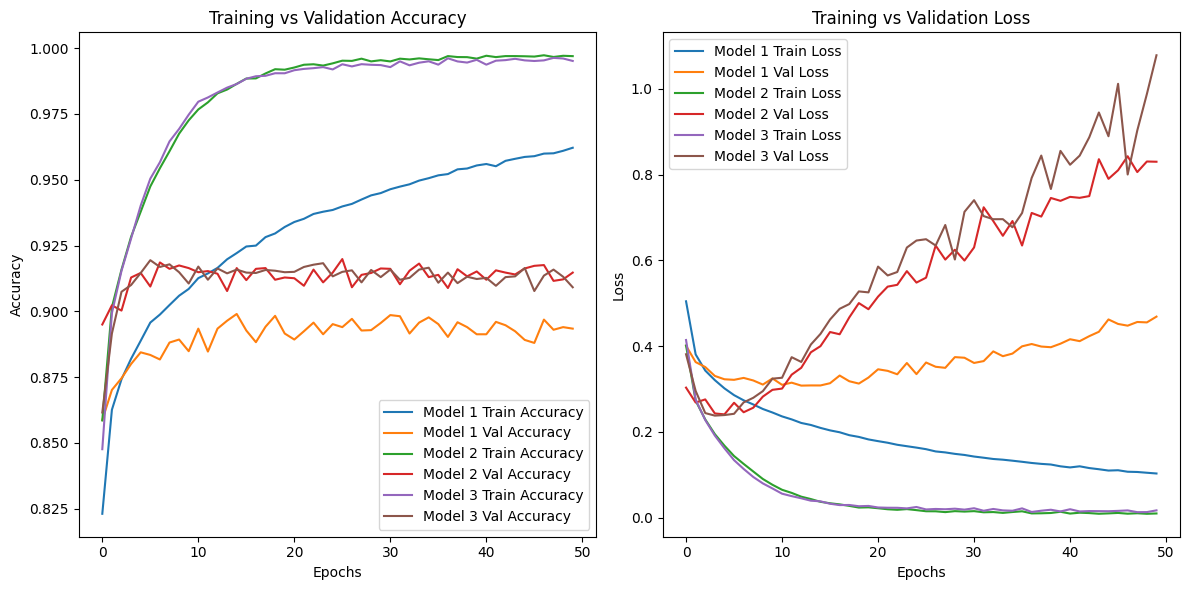

In [14]:
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Model 1 Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Model 1 Val Accuracy')
plt.plot(history2.history['accuracy'], label='Model 2 Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Model 2 Val Accuracy')
plt.plot(history3.history['accuracy'], label='Model 3 Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Model 3 Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Model 1 Train Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Val Loss')
plt.plot(history2.history['loss'], label='Model 2 Train Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Val Loss')
plt.plot(history3.history['loss'], label='Model 3 Train Loss')
plt.plot(history3.history['val_loss'], label='Model 3 Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation

#### Assess each model's performance on the test data, reporting accuracy.

In [15]:
test_loss, test_acc = model1.evaluate(x_test, y_test)
print(f"Test accuracy of Model 1: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.9015 - loss: 0.4672
Test accuracy of Model 1: 0.9010714292526245


In [16]:
test_loss, test_acc = model2.evaluate(x_test, y_test)
print(f"Test accuracy of Model 2: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.9220 - loss: 0.7595
Test accuracy of Model 2: 0.9203571677207947


In [17]:
test_loss, test_acc = model3.evaluate(x_test, y_test)
print(f"Test accuracy of Model 3: {test_acc}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9183 - loss: 0.9964
Test accuracy of Model 3: 0.9182142615318298


#### - Construct a committee by averaging predictions of the three models.
#### - Report on the combined accuracy of the committee.

In [18]:
# Get predictions for each model
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by averaging the predicted probabilities
final_predictions = (predictions1 + predictions2 + predictions3) / 3

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Committee accuracy: 0.9353571428571429


### Performance Metrics & Analysis:

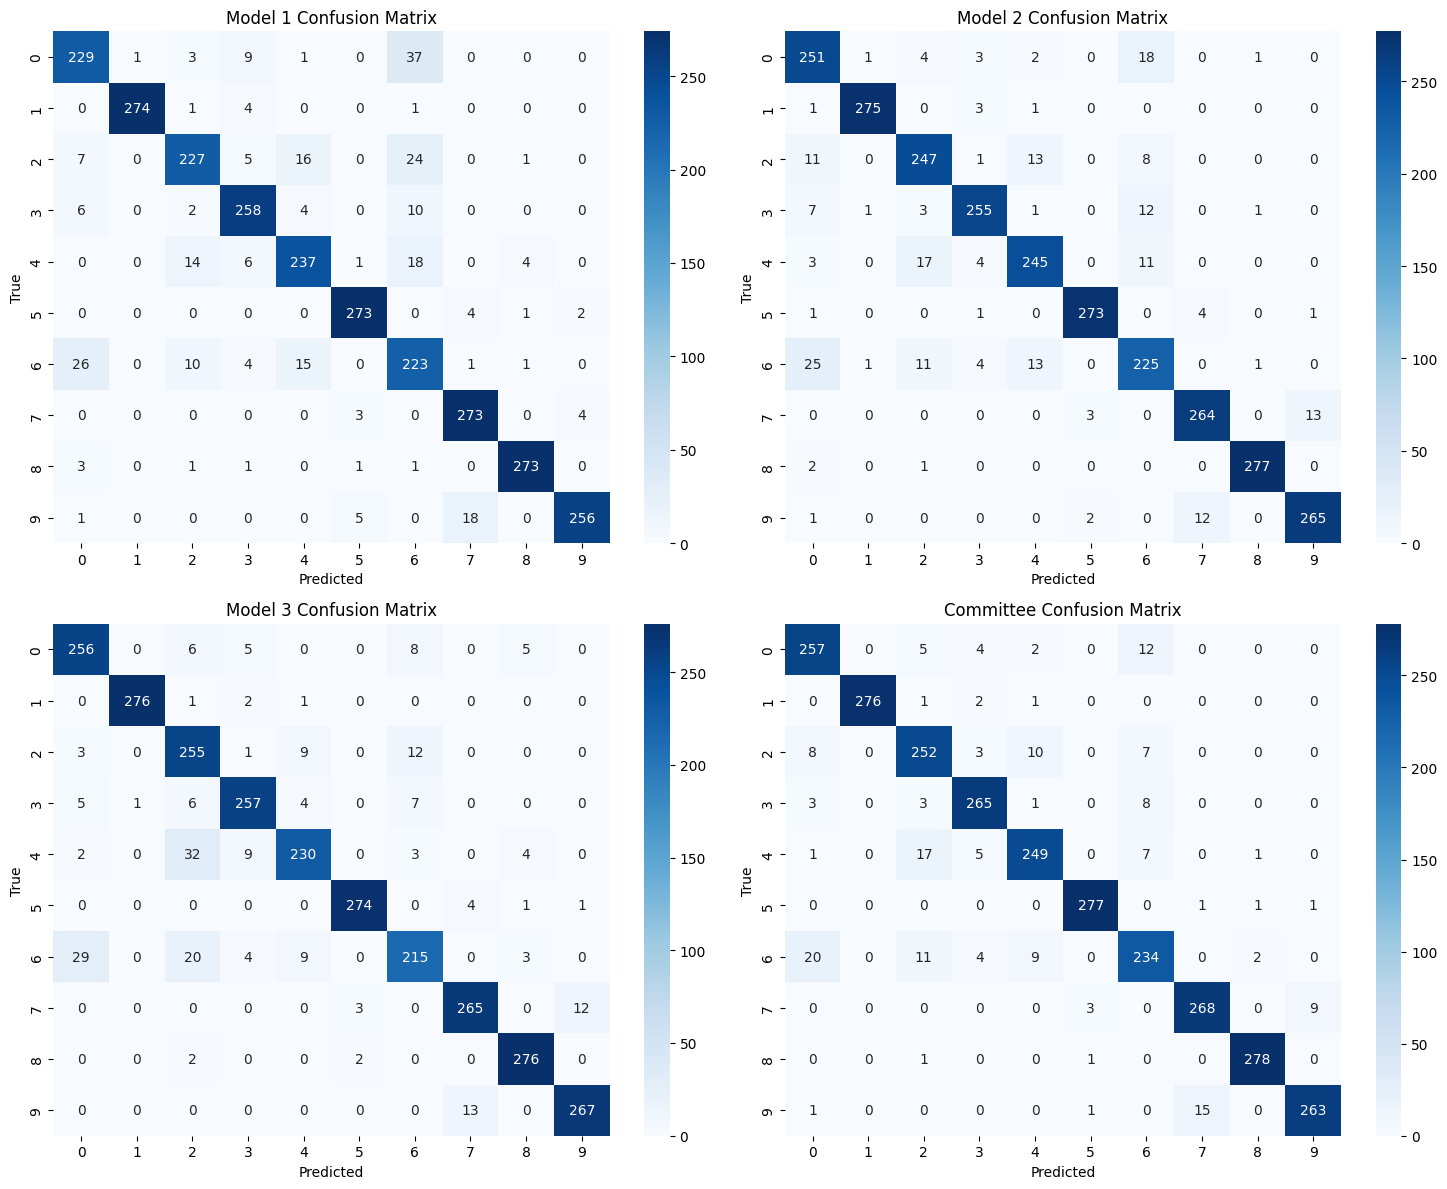

Model 1 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       280
           1       1.00      0.98      0.99       280
           2       0.88      0.81      0.84       280
           3       0.90      0.92      0.91       280
           4       0.87      0.85      0.86       280
           5       0.96      0.97      0.97       280
           6       0.71      0.80      0.75       280
           7       0.92      0.97      0.95       280
           8       0.97      0.97      0.97       280
           9       0.98      0.91      0.94       280

    accuracy                           0.90      2800
   macro avg       0.90      0.90      0.90      2800
weighted avg       0.90      0.90      0.90      2800

Model 2 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       280
           1       0.99      0.98      0.99       280
           2    

In [19]:
# Confusion matrix for models
cm1 = confusion_matrix(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cm2 = confusion_matrix(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cm3 = confusion_matrix(y_test.argmax(axis=1), predictions3.argmax(axis=1))

# Confusion matrix for the committee
cm_final = confusion_matrix(y_test.argmax(axis=1), final_predictions)

# Plot confusion matrix heatmaps
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# Model 1 Confusion Matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax[0, 0])
ax[0, 0].set_title("Model 1 Confusion Matrix")
ax[0, 0].set_xlabel('Predicted')
ax[0, 0].set_ylabel('True')

# Model 2 Confusion Matrix
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax[0, 1])
ax[0, 1].set_title("Model 2 Confusion Matrix")
ax[0, 1].set_xlabel('Predicted')
ax[0, 1].set_ylabel('True')

# Model 3 Confusion Matrix
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', ax=ax[1, 0])
ax[1, 0].set_title("Model 3 Confusion Matrix")
ax[1, 0].set_xlabel('Predicted')
ax[1, 0].set_ylabel('True')

# Committee Confusion Matrix
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', ax=ax[1, 1])
ax[1, 1].set_title("Committee Confusion Matrix")
ax[1, 1].set_xlabel('Predicted')
ax[1, 1].set_ylabel('True')

plt.tight_layout()
plt.show()

# Classification reports
cr1 = classification_report(y_test.argmax(axis=1), predictions1.argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), predictions2.argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), predictions3.argmax(axis=1))
cr_final = classification_report(y_test.argmax(axis=1), final_predictions)

# Print classification reports
print("Model 1 Classification Report:")
print(cr1)

print("Model 2 Classification Report:")
print(cr2)

print("Model 3 Classification Report:")
print(cr3)

print("Committee Classification Report:")
print(cr_final)


### Classification Report 

In [20]:
# Classification reports for each model and committee
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1), output_dict=True)
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1), output_dict=True)
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1), output_dict=True)
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions, output_dict=True)

# Convert the reports to DataFrame for easy visualization
df1 = pd.DataFrame(cr1).transpose()
df2 = pd.DataFrame(cr2).transpose()
df3 = pd.DataFrame(cr3).transpose()
df_committee = pd.DataFrame(cr_committee).transpose()

# Displaying the DataFrames in a readable format
print("Model 1 Classification Report")
print(df1)

print("Model 2 Classification Report")
print(df2)

print("Model 3 Classification Report")
print(df3)

print("Committee Classification Report")
print(df_committee)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model 1 Classification Report
              precision    recall  f1-score      support
0              0.841912  0.817857  0.829710   280.000000
1              0.996364  0.978571  0.987387   280.000000
2              0.879845  0.810714  0.843866   280.000000
3              0.898955  0.921429  0.910053   280.000000
4              0.868132  0.846429  0.857143   280.000000
5              0.964664  0.975000  0.969805   280.000000
6              0.710191  0.796429  0.750842   280.000000
7              0.922297  0.975000  0.947917   280.000000
8              0.975000  0.975000  0.975000   280.000000
9              0.977099  0.914286  0.944649   280.000000
accuracy       0.901071  0.901071  0.901071     0.901071
macro avg      0.903446  0.901071  0.901637  2800.000000
weighted avg   0.903446  0.901071  0.901637  2800.000000
Model 2 Classification Report
              precisi

## Extra Task

### Model Setup with Batch Normalization and Dropout

In [21]:
# Load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize the images to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reshaping for CNNs (adding channel dimension)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# One-hot encoding labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

### Data Augmentation

In [22]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

### Defining the model with Batch Normalization and Dropout

In [23]:
model = keras.Sequential([
    layers.InputLayer(input_shape=x_train.shape[1:]),  # Input shape (28, 28, 1)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes
])

/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Compiling the model

In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

### Train the model:
#### Train the model with data augmentation

In [25]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    epochs=50,
                    validation_data=(x_test, y_test))

Epoch 1/50


/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.6558 - loss: 1.0185 - val_accuracy: 0.8229 - val_loss: 0.4943
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.7755 - loss: 0.5920 - val_accuracy: 0.8580 - val_loss: 0.3882
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.8055 - loss: 0.5210 - val_accuracy: 0.8451 - val_loss: 0.4159
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.8225 - loss: 0.4789 - val_accuracy: 0.8691 - val_loss: 0.3422
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.8312 - loss: 0.4590 - val_accuracy: 0.8764 - val_loss: 0.3336
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.8401 - loss: 0.4356 - val_accuracy: 0.8747 - val_loss: 0.3374
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8452 - loss: 0.4204 - val_accuracy: 0.8317 - val_loss: 0.4644
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.8445 - loss: 0.4144 - val_accurac

In [26]:
model.save_weights('question2_fashion_mnist_model.weights.h5')

### Advanced ensembling:  (Weighted Averaging)

In [27]:
# Predictions from the models
predictions1 = model1.predict(x_test)
predictions2 = model2.predict(x_test)
predictions3 = model3.predict(x_test)

# Combine predictions (committee) by weighted averaging based on validation performance
weights = [0.5, 0.25, 0.25]  
final_predictions = (weights[0] * predictions1 + weights[1] * predictions2 + weights[2] * predictions3)

# Get the class with the highest probability for each prediction
final_predictions = final_predictions.argmax(axis=1)

# Compute accuracy for the committee
committee_accuracy = np.mean(final_predictions == y_test.argmax(axis=1))
print(f"Committee accuracy: {committee_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Committee accuracy: 0.987


### Confusion Matrix Heatmaps

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


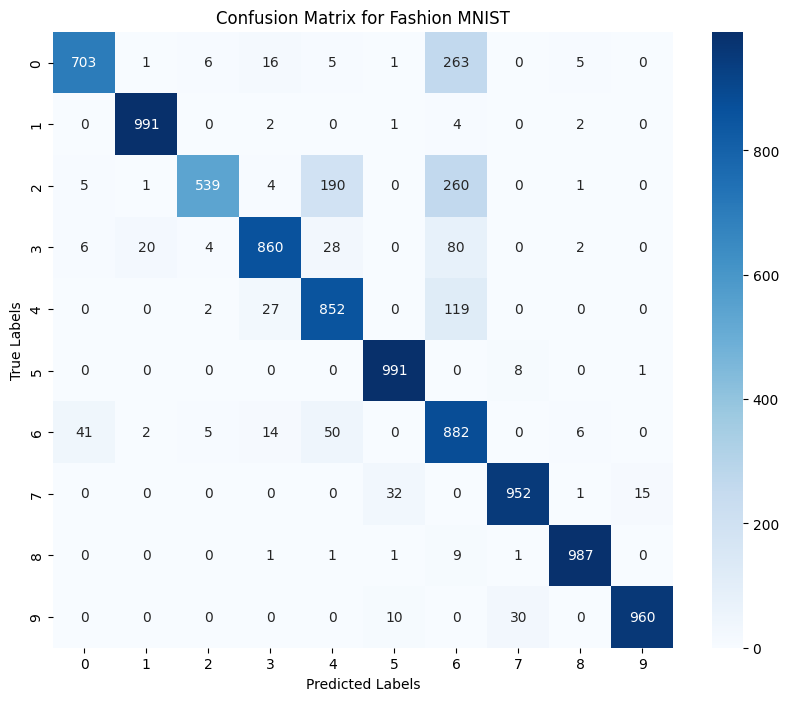

In [28]:
y_pred = model.predict(x_test)

# Converting predictions from one-hot encoded to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Converting true labels (y_test) from one-hot encoded to class indices
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix for Fashion MNIST")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

### Training Curves (Accuracy and Loss)

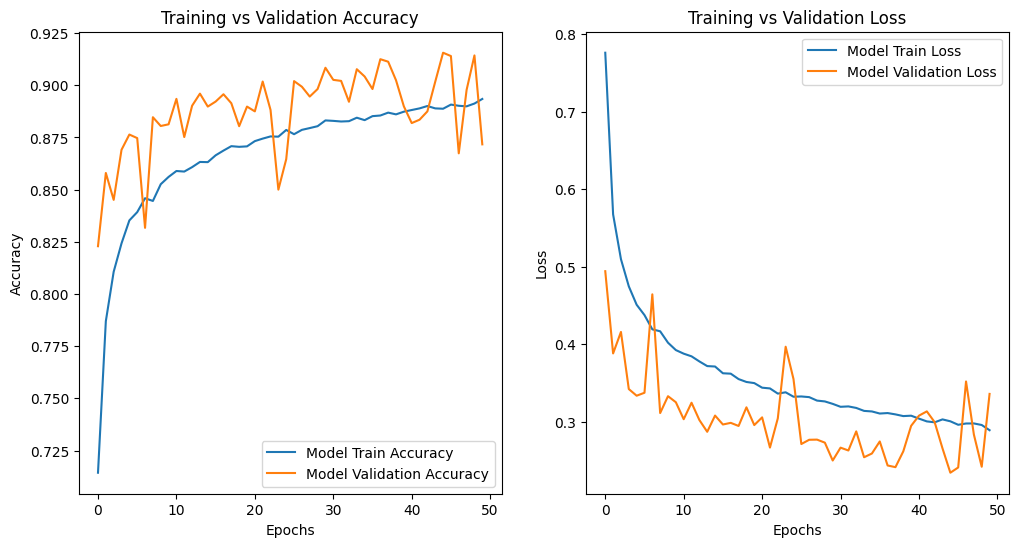

In [29]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Model Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Model Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Model Train Loss')
plt.plot(history.history['val_loss'], label='Model Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Classification Reports

In [30]:
# Classification reports for the committee and individual models
cr_committee = classification_report(y_test.argmax(axis=1), final_predictions)
print("Committee Classification Report")
print(cr_committee)

# classification reports for individual models like model1, model2, and model3
cr1 = classification_report(y_test.argmax(axis=1), model1.predict(x_test).argmax(axis=1))
cr2 = classification_report(y_test.argmax(axis=1), model2.predict(x_test).argmax(axis=1))
cr3 = classification_report(y_test.argmax(axis=1), model3.predict(x_test).argmax(axis=1))

print("Model 1 Classification Report")
print(cr1)
print("Model 2 Classification Report")
print(cr2)
print("Model 3 Classification Report")
print(cr3)

Committee Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1000
           1       1.00      0.99      1.00      1000
           2       0.97      0.98      0.98      1000
           3       0.98      0.98      0.98      1000
           4       0.99      0.97      0.98      1000
           5       1.00      1.00      1.00      1000
           6       0.96      0.96      0.96      1000
           7       1.00      1.00      1.00      1000
           8       0.99      1.00      0.99      1000
           9       1.00      1.00      1.00      1000

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 219us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Model 1 Classification Report
              precision    recall  f1-score   suppor

## Question 2: Network with Batch Normalization and Dropout Layers

![Neural Network Architecture](./architecture.png)

In [31]:
# Load and preprocess Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.reshape(-1, 28*28).astype("float32") / 255.0
x_test = x_test.reshape(-1, 28*28).astype("float32") / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Build the Wide & Deep model
input_layer = keras.Input(shape=(784,))

# Deep part
hidden1 = layers.Dense(30, activation='relu')(input_layer)
hidden1 = layers.BatchNormalization()(hidden1)
hidden1 = layers.Dropout(0.3)(hidden1)

hidden2 = layers.Dense(30, activation='relu')(hidden1)
hidden2 = layers.BatchNormalization()(hidden2)
hidden2 = layers.Dropout(0.3)(hidden2)

# Wide + Deep concat
concat = layers.Concatenate()([input_layer, hidden2])

# Output layer
output = layers.Dense(10, activation='softmax')(concat)

In [32]:
#  Final model
model = keras.Model(inputs=[input_layer], outputs=[output])

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 30)        │     23,550 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30)        │        120 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 30)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 30)        │        930 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30)        │        120 │ dense_9[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 30)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 814)       │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 10)        │      8,150 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,870 (128.40 KB)

 Trainable params: 32,750 (127.93 KB)

 Non-trainable params: 120 (480.00 B)

#### Train

In [33]:
history = model.fit(x_train, y_train_cat,
                    epochs=50,
                    batch_size=64,
                    validation_data=(x_test, y_test_cat))

Epoch 1/50


/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_31']
Received: inputs=Tensor(shape=(None, 784))
  warnings.warn(msg)


938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.7386 - loss: 0.7806 - val_accuracy: 0.8203 - val_loss: 0.4900
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8423 - loss: 0.4532 - val_accuracy: 0.8369 - val_loss: 0.4561
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 634us/step - accuracy: 0.8533 - loss: 0.4158 - val_accuracy: 0.8426 - val_loss: 0.4343
Epoch 4/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step - accuracy: 0.8575 - loss: 0.3996 - val_accuracy: 0.8439 - val_loss: 0.4359
Epoch 5/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.8613 - loss: 0.3908 - val_accuracy: 0.8499 - val_loss: 0.4141
Epoch 6/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 705us/step - accuracy: 0.8645 - loss: 0.3784 - val_accuracy: 0.8493 - val_loss: 0.4163
Epoch 7/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.8665 - loss: 0.3707 - val_accuracy: 0.8568 - val_loss: 0.3997
Epoch 8/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.8705 - loss: 0.3600 - val_accurac

In [34]:
# Save the best model weights
model.save_weights('q2_fashion_mnist_model_best.weights.h5')

# Model Evaluation
test_loss, test_acc = model.evaluate(x_test, to_categorical(y_test), verbose=2)
print(f"Test accuracy: {test_acc}")

313/313 - 0s - 366us/step - accuracy: 0.8678 - loss: 0.3749
Test accuracy: 0.8677999973297119


#### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step


/Users/asmae/Documents/GitHub/assignment3_ML/myenv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_31']
Received: inputs=Tensor(shape=(32, 784))
  warnings.warn(msg)


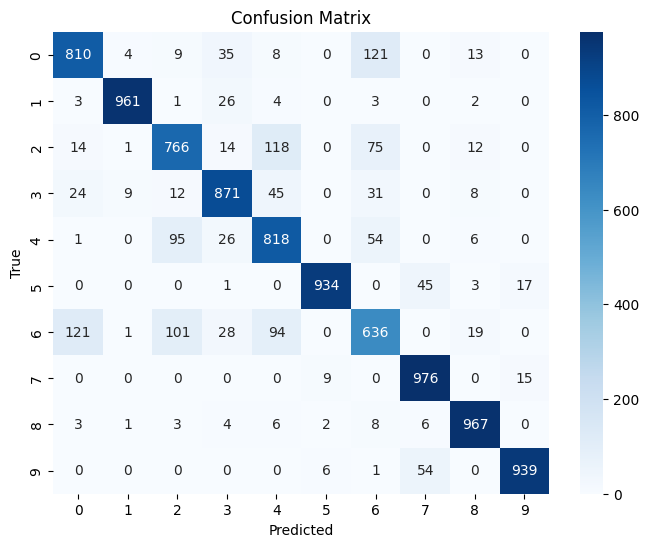

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.78      0.77      0.77      1000
           3       0.87      0.87      0.87      1000
           4       0.75      0.82      0.78      1000
           5       0.98      0.93      0.96      1000
           6       0.68      0.64      0.66      1000
           7       0.90      0.98      0.94      1000
           8       0.94      0.97      0.95      1000
           9       0.97      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [35]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test

cm = confusion_matrix(true_classes, predicted_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
cr = classification_report(true_classes, predicted_classes)
print("Classification Report")
print(cr)

#### Plotting training & validation accuracy and loss

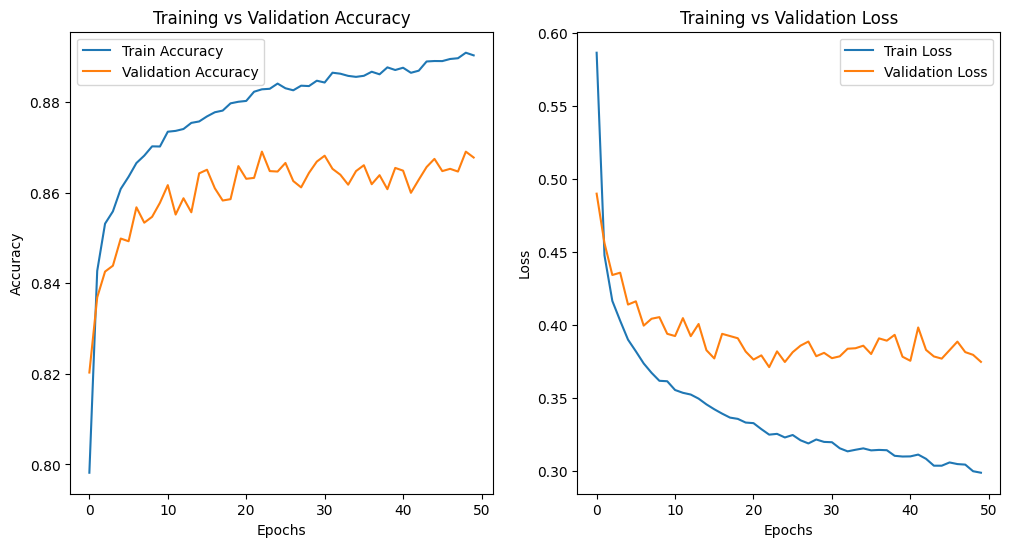

In [36]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()